# Dataset Formation - Tabular and Causal Inference

In this document I try creating the "tabular" version of this task. The goal is to leverage Propensity Score Matching between any choice of pairs of treatment, to compare them against each other in terms of impact in different scenarios.

For a particular row, corresponding to patiend id `pid` and timestamp `t`, we want to use:
* `static` features
* `categorical` features up until and including `t` timestep
* `target` features up until and NOT including `t` (until `t-1`).

In [98]:
# - preparing the master dataframe
from typing import List, Tuple
import os, sys
sys.path.insert(0, os.path.abspath('../../'))
from tqdm import tqdm
import random
import numpy
import pandas
import matplotlib.pyplot as plt
import torch
import torch.utils.data.dataset
import torch.utils.data.dataloader

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from tabulate import tabulate

from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *


from kp_problem.dataset.tabular import fetch_dataset

In this notebook, we want to answer the following question:

The relationship between the treatment (`Comp. NNRTI`) and the corresponding reward (`reward`), given the context.

In [99]:
%%time
df_features, df_targets, feature_groups = fetch_dataset(
    ewma_histories=False,
    ewma_alpha=0.8,
    ewma_adjust=True,
    prev_month=False,
    balance_by_n_rows_per_treatment=1000,
)

CPU times: user 16.3 s, sys: 163 ms, total: 16.5 s
Wall time: 16.5 s


In [100]:
df_features.columns.tolist()

['PatientID',
 'Timepoints',
 'Comp. NNRTI_0.0',
 'Comp. NNRTI_1.0',
 'Comp. NNRTI_2.0',
 'Comp. NNRTI_3.0',
 'Comp. INI_0.0',
 'Comp. INI_1.0',
 'Comp. INI_2.0',
 'Comp. INI_3.0',
 'Base Drug Combo_0.0',
 'Base Drug Combo_1.0',
 'Base Drug Combo_2.0',
 'Base Drug Combo_3.0',
 'Base Drug Combo_4.0',
 'Base Drug Combo_5.0',
 'Drug (M)_0.0',
 'Drug (M)_1.0',
 'Extra PI_0.0',
 'Extra PI_1.0',
 'Extra PI_2.0',
 'Extra PI_3.0',
 'Extra PI_4.0',
 'Extra PI_5.0',
 'Extra pk-En_0.0',
 'Extra pk-En_1.0',
 'Gender_1.0',
 'Gender_2.0',
 'Ethnic_2.0',
 'Ethnic_3.0',
 'Ethnic_4.0']

In [101]:
psm_df = df_features.copy()

t1 = 0 # treatment
t2 = 3 # control
psm_df = psm_df[(psm_df[f'Comp. NNRTI_{t1}.0'] == 1) + (psm_df[f'Comp. NNRTI_{t2}.0'] == 1)]


psm_df['treatment'] = psm_df.apply(lambda x: x[f'Comp. NNRTI_{t1}.0'], axis=1)
psm_df.drop(columns=[f'Comp. NNRTI_{i}.0' for i in range(4)], inplace=True)
psm_df['the_index'] = psm_df.apply(lambda x: f"{x['PatientID']}_{x['Timepoints']}", axis=1)
psm_df = pandas.merge(psm_df, df_targets.loc[:, ['PatientID', 'Timepoints', 'reward', 'reward_advantage']], on=['PatientID', 'Timepoints'], how='inner')
psm_df.head()

,PatientID,Timepoints,Comp. INI_0.0,Comp. INI_1.0,Comp. INI_2.0,Comp. INI_3.0,Base Drug Combo_0.0,Base Drug Combo_1.0,Base Drug Combo_2.0,Base Drug Combo_3.0,...,Extra pk-En_1.0,Gender_1.0,Gender_2.0,Ethnic_2.0,Ethnic_3.0,Ethnic_4.0,treatment,the_index,reward,reward_advantage
0,6256,0.4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,6256.0_0.4,1.330747,-2.005791
1,1942,0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1942.0_0.5,2.092466,-0.940333
2,3324,0.2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3324.0_0.2,1.088520,-1.810478
3,3324,0.2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3324.0_0.2,1.088520,-1.810478
4,3324,0.2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3324.0_0.2,1.088520,-1.810478


In [114]:
psm_df.columns.tolist()

['PatientID',
 'Timepoints',
 'Comp. INI_0.0',
 'Comp. INI_1.0',
 'Comp. INI_2.0',
 'Comp. INI_3.0',
 'Base Drug Combo_0.0',
 'Base Drug Combo_1.0',
 'Base Drug Combo_2.0',
 'Base Drug Combo_3.0',
 'Base Drug Combo_4.0',
 'Base Drug Combo_5.0',
 'Drug (M)_0.0',
 'Drug (M)_1.0',
 'Extra PI_0.0',
 'Extra PI_1.0',
 'Extra PI_2.0',
 'Extra PI_3.0',
 'Extra PI_4.0',
 'Extra PI_5.0',
 'Extra pk-En_0.0',
 'Extra pk-En_1.0',
 'Gender_1.0',
 'Gender_2.0',
 'Ethnic_2.0',
 'Ethnic_3.0',
 'Ethnic_4.0',
 'treatment',
 'the_index',
 'reward',
 'reward_advantage']

In [102]:
psm_df.isna().sum().sum()

0

In [103]:
psm = PsmPy(psm_df, treatment='treatment', indx='the_index', exclude = ['PatientID', 'Timepoints', 'reward', 'reward_advantage'])
psm.logistic_ps(balance = True)

In [104]:
# psm.knn_matched_12n(matcher='propensity_logit', replacement=False, caliper=None, how_many=1)
psm.knn_matched_12n(matcher='propensity_logit', how_many=1)

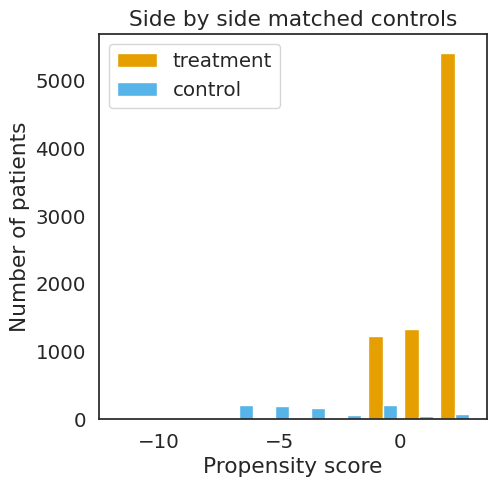

In [112]:
plt.figure(figsize=(5,5))
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of patients', Xlabel= 'Propensity score', names = ['treatment', 'control'], save=True)

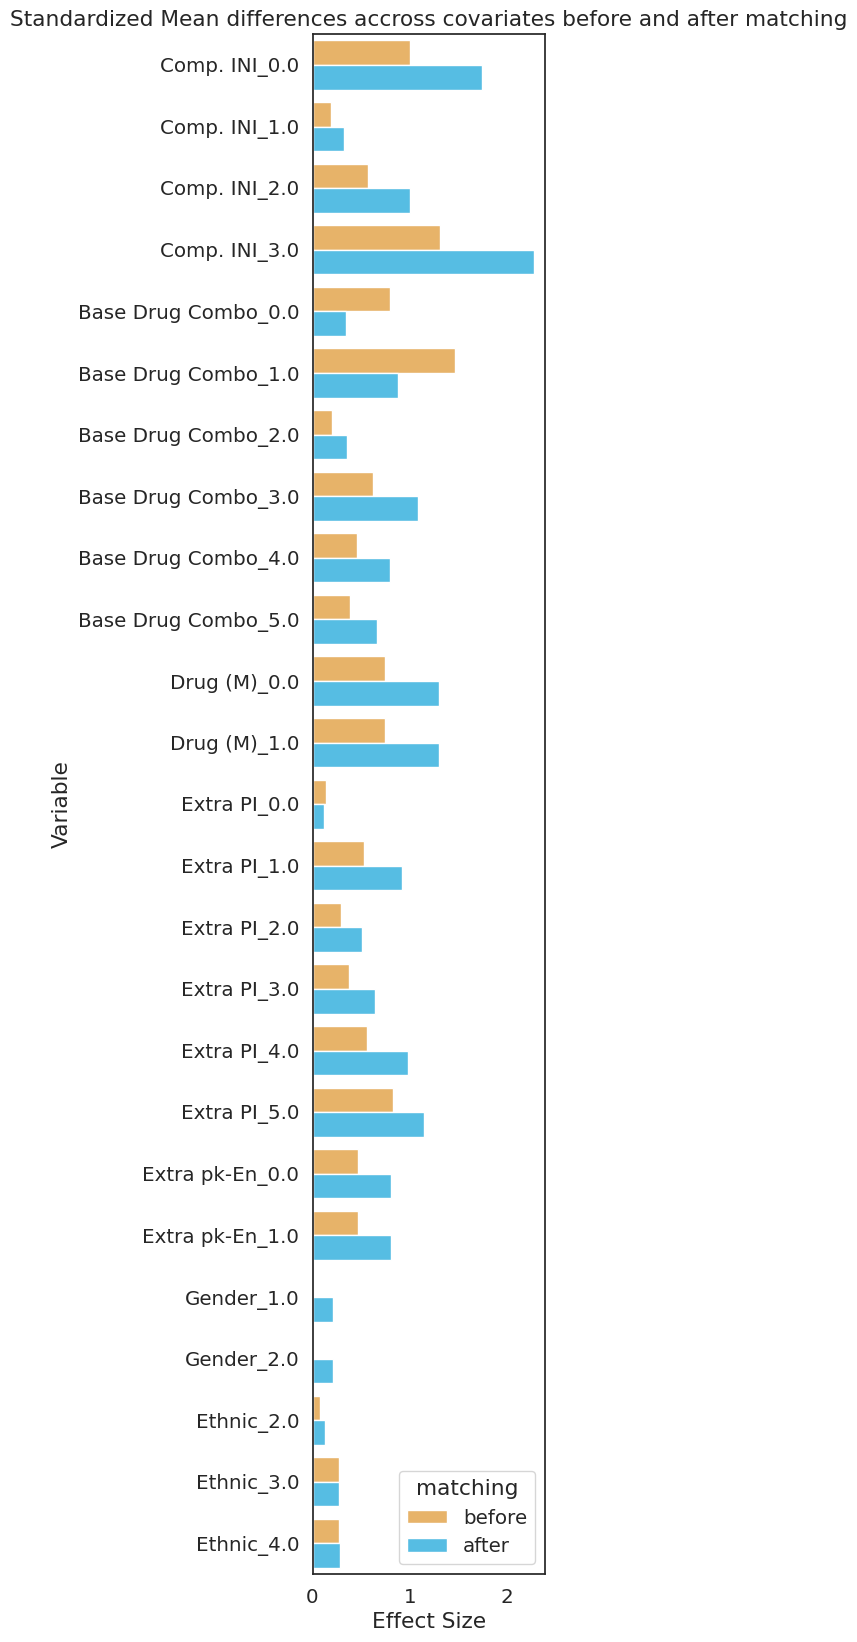

In [113]:
plt.figure(figsize=(3,20))
psm.effect_size_plot(save=False)

In [107]:
psm.matched_ids

,the_index,largerclass_0group
0,4107.0_0.3333333333333333,5284.0_0.5
1,4025.0_0.31666666666666665,3980.0_0.2
2,8791.0_0.11666666666666667,7961.0_0.3
3,3684.0_0.15,4310.0_0.2
4,198.0_0.5166666666666667,5117.0_0.2
...,...,...
1001,1053.0_0.45,3099.0_0.8
1002,452.0_0.7833333333333333,6297.0_0.8
1003,7935.0_0.95,6297.0_0.8
1004,6573.0_0.8,6383.0_0.7


In [108]:
df_matched = psm.df_matched.copy().set_index('the_index')

In [109]:
c = psm.matched_ids.sample(1)
pandas.concat((df_matched.loc[c.the_index], df_matched.loc[c.largerclass_0group]))

,Comp. INI_0.0,Comp. INI_1.0,Comp. INI_2.0,Comp. INI_3.0,Base Drug Combo_0.0,Base Drug Combo_1.0,Base Drug Combo_2.0,Base Drug Combo_3.0,Base Drug Combo_4.0,Base Drug Combo_5.0,...,Extra pk-En_0.0,Extra pk-En_1.0,Gender_1.0,Gender_2.0,Ethnic_2.0,Ethnic_3.0,Ethnic_4.0,propensity_score,propensity_logit,treatment
the_index,,,,,,,,,,,,,,,,,,,,,
1227.0_0.2833333333333333,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.520893,0.083620,0
5700.0_0.21666666666666667,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.475212,-0.099233,1
5700.0_0.21666666666666667,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.475212,-0.099233,1
5700.0_0.21666666666666667,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.475212,-0.099233,1
5700.0_0.21666666666666667,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.475212,-0.099233,1
5700.0_0.21666666666666667,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.475212,-0.099233,1
5700.0_0.21666666666666667,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.475212,-0.099233,1
5700.0_0.21666666666666667,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.475212,-0.099233,1
5700.0_0.21666666666666667,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.475212,-0.099233,1


In [110]:
df_matched.groupby('treatment').describe().loc[:, ['propensity_score']]

propensity_score                                                    \
                     count      mean       std       min       25%       50%   
treatment                                                                      
0                   1006.0  0.164129  0.256824  0.000007  0.002810  0.017128   
1                   7970.0  0.737782  0.216926  0.255982  0.566574  0.866876   

                               
                75%       max  
treatment                      
0          0.275478  0.953151  
1          0.866876  0.953151